In [1]:
import os
import cv2 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras import preprocessing 

# Load images into keras

In [2]:
# create list of folder names as classes
classes = ['apple', 'banana', 'cup', 'empty','glass','juice','lotion','pear']

# define the base path of images
base_path = './imageclassifier-main/data/'

In [3]:
# define an image data generator
data_gen = preprocessing.image.ImageDataGenerator(
    # define the preprocessing function that should be applied to all images
    preprocessing_function=mobilenet_v2.preprocess_input,
    # fill_mode='nearest',
    # rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # horizontal_flip=True, 
    # zoom_range=0.2,
    # shear_range=0.2    
)

In [4]:
# generate X and y arrays
train_data_gen = data_gen.flow_from_directory(
                                              directory= base_path,
                                              class_mode='categorical',
                                              classes=classes,
                                              batch_size=450,
                                              target_size=(224,224),
                                              )

Found 1110 images belonging to 8 classes.


In [5]:
# load in all images at once
xtrain, ytrain = next(train_data_gen)
xtrain.shape, ytrain.shape

((450, 224, 224, 3), (450, 8))

In [6]:
classes

['apple', 'banana', 'cup', 'empty', 'glass', 'juice', 'lotion', 'pear']

# Create CNN model

In [7]:
base_model = mobilenet_v2.MobileNetV2(
    weights='imagenet', 
    alpha=0.35,         # specific parameter of this model, small alpha reduces the number of overall weights
    pooling='avg',      # applies global average pooling to the output of the last conv layer (like a flattening)
    include_top=False,  # <------ !!!!! we only want to have the base, not the final dense layers 
    input_shape=(224, 224, 3)
)

In [8]:
base_model.summary()

Model: "mobilenetv2_0.35_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 16) 432         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 16) 64          Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 16) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [9]:
# freeze the weights
base_model.trainable = False

In [10]:
base_model.summary()

Model: "mobilenetv2_0.35_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 16) 432         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 16) 64          Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 16) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [11]:
# create the model
model = keras.Sequential()
model.add(base_model)
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(len(classes), activation='softmax'))

In [12]:
# have a look at the trainable and non-trainable params statistic
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_0.35_224 (Functi (None, 1280)              410208    
_________________________________________________________________
dense (Dense)                (None, 100)               128100    
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 808       
Total params: 539,116
Trainable params: 128,908
Non-trainable params: 410,208
_________________________________________________________________


In [13]:
#compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=keras.losses.categorical_crossentropy,
              metrics=[keras.metrics.categorical_accuracy])

In [14]:
# observe the validation loss and stop when it does not improve after 2 iterations
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

In [15]:
model.fit(xtrain, ytrain, 
          epochs=50, 
          verbose=2,
          batch_size=50, 
          callbacks=[callback],
          # use 30% of the data for validation
          validation_split=0.2)

Epoch 1/50
8/8 - 6s - loss: 1.1901 - categorical_accuracy: 0.6389 - val_loss: 0.1801 - val_categorical_accuracy: 0.9778
Epoch 2/50
8/8 - 3s - loss: 0.2157 - categorical_accuracy: 0.9639 - val_loss: 0.0502 - val_categorical_accuracy: 0.9889
Epoch 3/50
8/8 - 5s - loss: 0.0885 - categorical_accuracy: 0.9806 - val_loss: 0.0192 - val_categorical_accuracy: 1.0000
Epoch 4/50
8/8 - 5s - loss: 0.0409 - categorical_accuracy: 0.9944 - val_loss: 0.0102 - val_categorical_accuracy: 1.0000
Epoch 5/50
8/8 - 5s - loss: 0.0321 - categorical_accuracy: 0.9972 - val_loss: 0.0062 - val_categorical_accuracy: 1.0000
Epoch 6/50
8/8 - 4s - loss: 0.0258 - categorical_accuracy: 0.9972 - val_loss: 0.0052 - val_categorical_accuracy: 1.0000
Epoch 7/50
8/8 - 4s - loss: 0.0243 - categorical_accuracy: 0.9944 - val_loss: 0.0034 - val_categorical_accuracy: 1.0000
Epoch 8/50
8/8 - 4s - loss: 0.0102 - categorical_accuracy: 1.0000 - val_loss: 0.0027 - val_categorical_accuracy: 1.0000
Epoch 9/50
8/8 - 4s - loss: 0.0144 - cat

In [27]:
#predict an image
from tensorflow.keras.preprocessing import image
img = image.load_img('./imageclassifier-main/data/cup/12-25-13-559476.png')

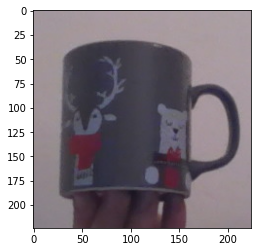

In [28]:
plt.imshow(img)

In [29]:
a = image.img_to_array(img)

In [30]:
a = np.expand_dims(a, axis = 0)

In [31]:
model.predict(a)

array([[0.01485409, 0.00250118, 0.47434053, 0.00621726, 0.05588382,
        0.26592284, 0.13271996, 0.04756028]], dtype=float32)

In [32]:
model.predict(a)[0].round(decimals = 3)

array([0.015, 0.003, 0.474, 0.006, 0.056, 0.266, 0.133, 0.048],
      dtype=float32)

<BarContainer object of 8 artists>

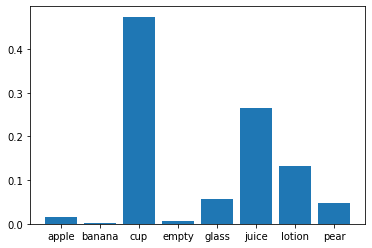

In [33]:
plt.bar(x = classes, height = model.predict(a)[0])

In [ ]:
#model.save('./imageclassifier-main/models/model_trans_l.h5')